In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40133,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:39619,Total threads: 8
Dashboard: http://127.0.0.1:39113/status,Memory: 62.93 GiB
Nanny: tcp://127.0.0.1:39775,


In [2]:
import xgcm
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import cmocean.cm as cmo
from xmitgcm import open_mdsdataset

plt.rcParams['font.size'] = 15

In [4]:
filename_heat = 'diag_heat_budget'
filename_kpp = 'diag_kpp'
filename_mom_u = 'diag_mom_u'
filename_state = 'diag_state'
filename_surf = 'diag_surf'

zMin = -250
zMax = 0
lon = 220.0
latMin = -0.1
latMax = 0.1

data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_withhold/run_iter14/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state,filename_mom_u,filename_heat,filename_surf]
ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds['XC'] = ds.XC.astype(float)
ds['YC'] = ds.YC.astype(float)
ds['Z'] = ds.Z.astype(float)
ds['XG'] = ds.XG.astype(float)
ds['YG'] = ds.YG.astype(float)
ds['Zl'] = ds.Zl.astype(float)

In [5]:
folder_name = '/home/edavenport/analysis/mitgcm-mombudg/velocity_assim/sep2012_velwithhold_iter14/'

In [6]:
grid = xgcm.Grid(ds, periodic=['X','Y'])
vol = (ds.rAw*ds.hFacW*ds.drF)
KPP_momU = grid.diff(ds.VISrI_Um,'Z',boundary='fill',fill_value=0)/vol
KPP_momU = KPP_momU.where(ds.hFacW.values > 0,0) # set any nan fluxes to 0
ds['Um_Advec'] = ds.Um_Advec - ds.Um_Cori

In [7]:
decorr_scale_days = 5 # see DecorrelationScales_MBTerms.py
N_ind = (90)/decorr_scale_days # approximate number of days in a season
std_err_denom = np.sqrt(N_ind)

In [8]:
RHS = (KPP_momU.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') +  
    ds.Um_Advec.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') +  
    ds.Um_Cori.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') + 
    ds.Um_Ext.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') + 
    ds.Um_dPhiX.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') + 
    ds.AB_gU.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') + 
    ds.Um_Diss.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest')).squeeze()

TOTUTEND = ds.TOTUTEND.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze()/86400

In [9]:
Um_TOT = TOTUTEND.mean(dim='YC').mean(dim='time').compute()
Um_RHS = RHS.mean(dim='YC').mean(dim='time').compute()
Um_TOT_mean = TOTUTEND.mean(dim='YC').mean(dim='time').compute()
Um_RHS_mean = RHS.mean(dim='YC').mean(dim='time').compute()
Um_TOT_std = TOTUTEND.std(dim='YC').std(dim='time').compute()/std_err_denom
Um_RHS_std = RHS.std(dim='YC').std(dim='time').compute()/std_err_denom

/home/edavenport/miniconda3/envs/mitgcm_analysis/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/edavenport/miniconda3/envs/mitgcm_analysis/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/edavenport/miniconda3/envs/mitgcm_analysis/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/edavenport/miniconda3/envs/mitgcm_analysis/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/edavenport/miniconda3/envs/mitgcm_analysis/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cac

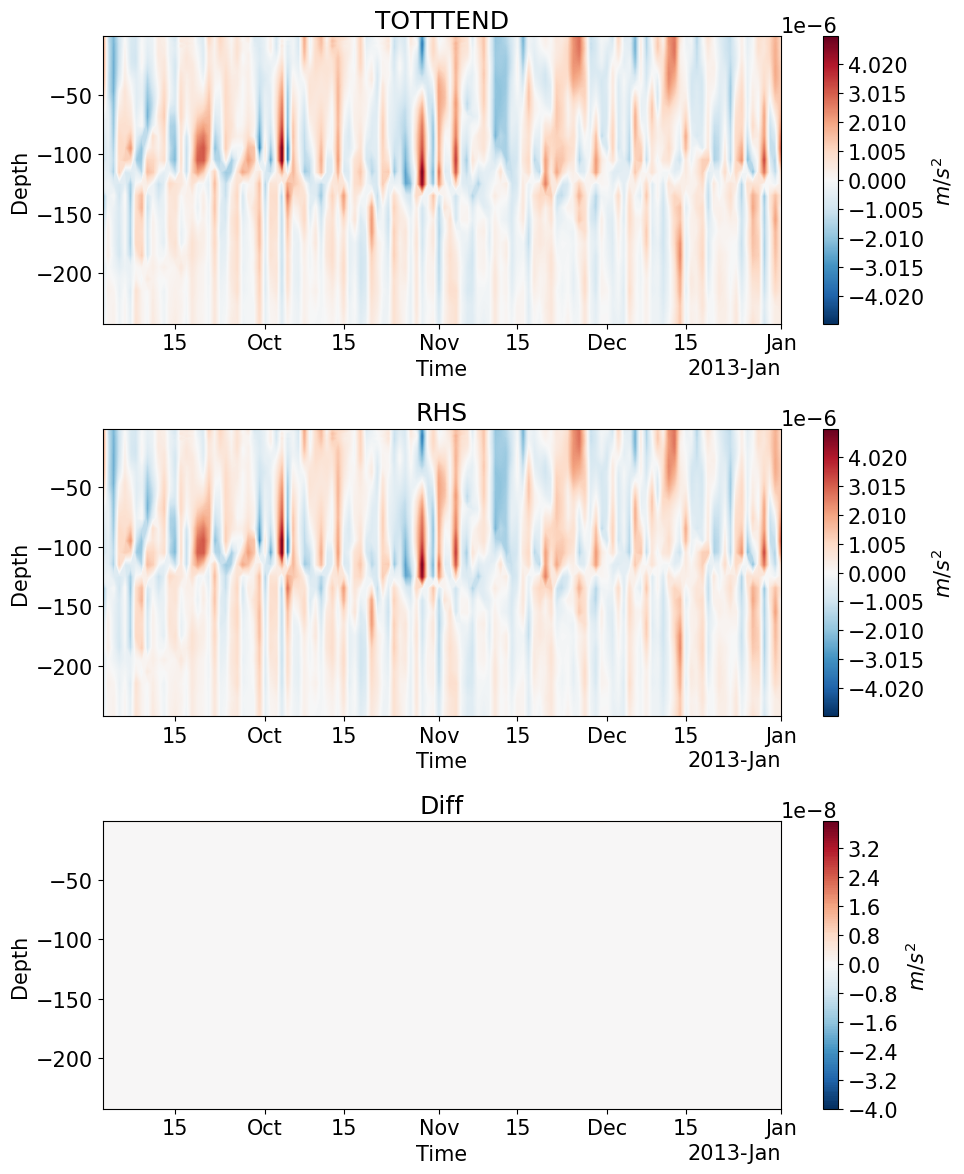

In [10]:
from matplotlib.colors import TwoSlopeNorm

vmin = -5e-6
vmax = 5e-6
levels = np.arange(vmin,vmax,0.5e-8)

fig, ax = plt.subplots(figsize=(10,12),nrows=3,ncols=1)
TOTUTEND.mean(dim='YC').plot.contourf(ax=ax[0],x='time',y='Z',levels=levels,cmap='RdBu_r',cbar_kwargs={'label':'$m/s^2$'},norm=TwoSlopeNorm(vmin=vmin,vcenter=0,vmax=vmax))
ax[0].set_title('TOTTTEND')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Depth')

RHS.mean(dim='YC').plot.contourf(ax=ax[1],x='time',y='Z',levels=levels,cmap='RdBu_r',cbar_kwargs={'label':'$m/s^2$'},norm=TwoSlopeNorm(vmin=vmin,vcenter=0,vmax=vmax))
ax[1].set_title('RHS')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Depth')

vmin = -4e-8
vmax = 4e-8
levels = np.arange(vmin,vmax,0.5e-9)
diff = TOTUTEND - RHS 
diff.mean(dim='YC').plot.contourf(ax=ax[2],x='time',y='Z',levels=levels,cmap='RdBu_r',cbar_kwargs={'label':'$m/s^2$'},norm=TwoSlopeNorm(vmin=vmin,vcenter=0,vmax=vmax))
ax[2].set_title('Diff')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Depth')
plt.tight_layout()

fig.savefig(folder_name+'mombudget_closure_timeseries.png')

In [11]:
KPP_momU = KPP_momU.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
Um_Advec = ds.Um_Advec.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
Um_Ext = ds.Um_Ext.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
Um_dPhiX = ds.Um_dPhiX.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()

KPP_momU_mean = KPP_momU.mean(dim='time').compute()
KPP_momU_std = KPP_momU.std(dim='time').compute()/std_err_denom
Um_Advec_mean = Um_Advec.mean(dim='time').compute()
Um_Advec_std = Um_Advec.std(dim='time').compute()/std_err_denom
Um_Ext_mean = Um_Ext.mean(dim='time').compute()
Um_Ext_std = Um_Ext.std(dim='time').compute()/std_err_denom
Um_dPhiX_mean = Um_dPhiX.mean(dim='time').compute()
Um_dPhiX_std = Um_dPhiX.std(dim='time').compute()/std_err_denom

In [12]:
Um_Ext_mean = Um_Ext.mean(dim='time').compute()
Um_Ext_std = Um_Ext.std(dim='time').compute()/std_err_denom

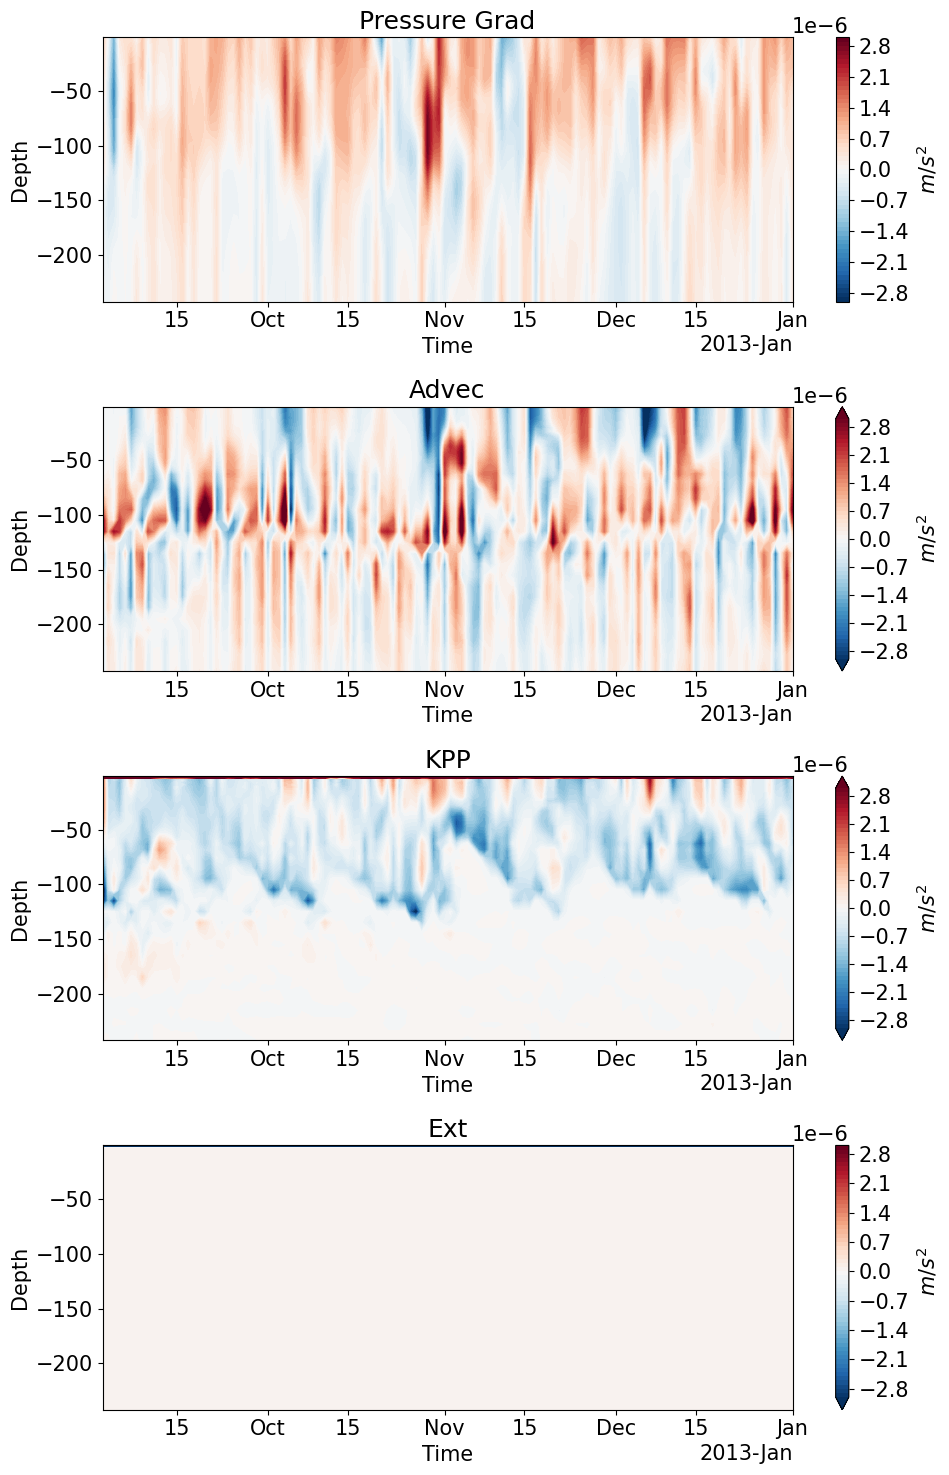

In [13]:
vmin = -3e-6
vmax = 3e-6
levels = np.arange(vmin,vmax,1e-7)

fig, ax = plt.subplots(figsize=(10,15),nrows=4,ncols=1)
Um_dPhiX.plot.contourf(ax=ax[0],x='time',y='Z',levels=levels,cmap='RdBu_r',cbar_kwargs={'label':'$m/s^2$'},norm=TwoSlopeNorm(vmin=vmin,vcenter=0,vmax=vmax))
ax[0].set_title('Pressure Grad')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Depth')

Um_Advec.plot.contourf(ax=ax[1],x='time',y='Z',levels=levels,cmap='RdBu_r',cbar_kwargs={'label':'$m/s^2$'},norm=TwoSlopeNorm(vmin=vmin,vcenter=0,vmax=vmax))
ax[1].set_title('Advec')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Depth')

KPP_momU.plot.contourf(ax=ax[2],x='time',y='Z',levels=levels,cmap='RdBu_r',cbar_kwargs={'label':'$m/s^2$'},norm=TwoSlopeNorm(vmin=vmin,vcenter=0,vmax=vmax))
ax[2].set_title('KPP')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Depth')

Um_Ext.plot.contourf(ax=ax[3],x='time',y='Z',levels=levels,cmap='RdBu_r',cbar_kwargs={'label':'$m/s^2$'},norm=TwoSlopeNorm(vmin=vmin,vcenter=0,vmax=vmax))
ax[3].set_title('Ext')
ax[3].set_xlabel('Time')
ax[3].set_ylabel('Depth')
plt.tight_layout()

fig.savefig(folder_name+'mombudget_terms_timeseries.png')

In [14]:
uvel = ds.UVEL.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
EUC_Core = ds.Z[uvel.argmax(dim='Z')].mean(dim='time').compute()

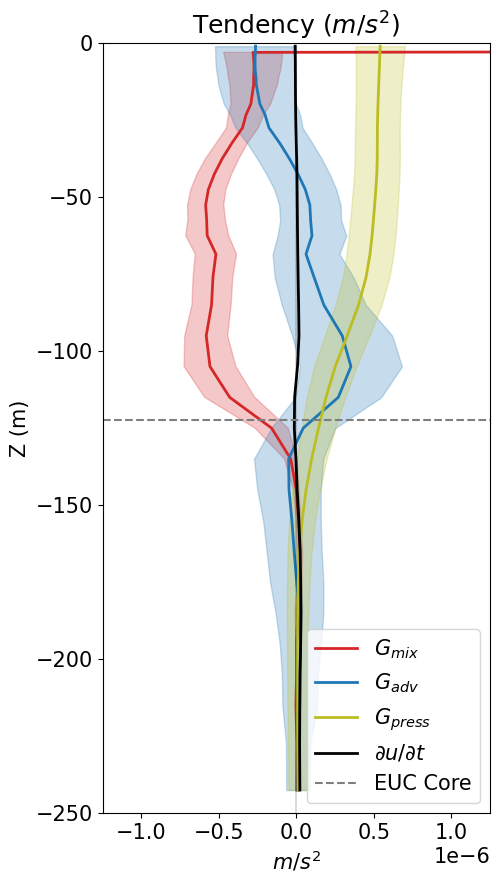

In [15]:
xmin = -1.25*(10**-6)
xmax = 1.25*(10**-6)

fig, ax = plt.subplots(figsize=(5,10))
KPP_momU_mean.plot(ax=ax,y='Z',linewidth=2.0,color='tab:red',label=r'$G_{mix}$')
ax.fill_betweenx(KPP_momU_mean.Z,KPP_momU_mean-KPP_momU_std,KPP_momU_mean+KPP_momU_std,color='tab:red',label='_nolegend_',alpha=0.25)
Um_Advec_mean.plot(ax=ax,y='Z',linewidth=2.0,color='tab:blue',label=r'$G_{adv}$')
ax.fill_betweenx(Um_Advec_mean.Z,Um_Advec_mean-Um_Advec_std,Um_Advec_mean+Um_Advec_std,color='tab:blue',label='_nolegend_',alpha=0.25)
Um_dPhiX_mean.plot(ax=ax,y='Z',linewidth=2.0,color='tab:olive',label=r'$G_{press}$')
ax.fill_betweenx(Um_dPhiX_mean.Z,Um_dPhiX_mean-Um_dPhiX_std,Um_dPhiX_mean+Um_dPhiX_std,color='tab:olive',label='_nolegend_',alpha=0.25)
Um_TOT_mean.plot(ax=ax,y='Z',linewidth=2.0,color='k',label=r'$\partial u/\partial t$')
ax.axvline(0,linestyle='--',linewidth=0.3,color='k')
ax.axhline(EUC_Core,linestyle='--',linewidth=1.5,color='tab:gray',label='EUC Core')
ax.set_ylim(zMin,0)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower right')
ax.set_title('Tendency ($m/s^2$)')
ax.set_xlabel('$m/s^2$')
ax.set_ylabel('Z (m)')

fig.savefig(folder_name+'mombudget_terms_meanprof.png')

In [16]:
cluster.close()
client.shutdown()
client.close()